# Thống kê Bayes sử dụng Probflow

# Bài 3: ANOVA đơn biến

### Bs. Lê Ngọc Khả Nhi

# Giới thiệu

Chào các bạn, đây là bài thứ 3 trong loạt bài giới thiệu về probflow, một giao thức dựa trên tensorflow hoặc pytorch cho phép dựng các mô hình Bayes một cách dễ dàng.

Trong bài này, chúng ta sẽ tìm hiểu về môt ứng dụng đơn giản của mô hình hồi quy tuyến tính đa biến, đó là so sánh trung bình bắt cặp tuần tự giữa nhiều phân nhóm. Có thể xem đây là sự mở rộng của kiểm định t, hoặc tương đương với post hoc test trong ANOVA đơn biến. 

# Bài toán minh họa

Nhi sử dụng lại dataset khảo sát độ dày màng phế nang (biến Thickness) giữa 3 phân nhóm : bệnh nhân khí phế thũng (Emphysema), bệnh nhân xơ phổi (Fibrosis) và nhóm chứng (người bình thường, Normal).

Câu hỏi nghiên cứu so sánh của chúng ta có thể được chuyển thành mô hình như sau:

Ta giả định biến Thickness được mô tả bằng một biến số ngẫu nhiên liên tục theo phân phối Student t:

$ Thickness \sim Student \text_t(\nu, \mu, \sigma)$

tham số $\mu$ lại được ước tính bởi mô hình tuyến tính đa biến:

$\mu \sim \mathbf{x}^\top \mathbf{w} = x_1 w_1 + x_2 w_2 + x_3 w_3$

Với x là design matrix, chứa x1, x2, x3 tương ứng với dummy variable của 3 phân nhóm cần so sánh

Mục tiêu của chúng ta là xác định ma trận w gồm 3 tham số w_1, w_2 và w_3

Chú ý: như vậy mô hình này không có intercept

In [1]:
import probflow as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

from patsy import dmatrices  # Tạo design matrix

import arviz as az

In [2]:
from sinfo import sinfo
sinfo()

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

-----
arviz                       0.7.0
matplotlib                  3.2.1
numpy                       1.18.3
pandas                      1.0.3
patsy                       0.5.1
probflow                    2.0.0a2
seaborn                     0.10.0
sinfo                       0.3.1
tensorflow                  2.0.0
tensorflow_probability      0.8.0
-----
IPython             7.12.0
jupyter_client      5.3.4
jupyter_core        4.6.1
jupyterlab          1.2.6
notebook            6.0.3
-----
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
8 logical CPU cores, Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
-----
Session information updated at 2020-05-18 19:43
SUCCESS: Found GPU: /device:GPU:0


# Bước 1: Chuẩn bị design matrix

Đầu tiên, Nhi tải dữ liệu csv và lưu thành dataframe df

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/aerodim.csv",sep=";")
df.head()

,Poids,Taille,BMI,Age,Sexe,Hb,Diagnostic,GST,Volume,Surface,DmCO,Thickness,DLCO,FVC
0,53,165,19.467401,54,F,13.4,E,1.284048,7.0080,19.647869,450.315872,0.142701,6.767,2.30
1,92,170,31.833910,75,H,17.1,E,1.291861,3.7750,10.519710,72.271882,0.476060,19.146,3.04
2,69,186,19.944502,41,H,14.6,E,1.211214,7.7695,23.092705,372.142895,0.202952,29.047,5.72
3,60,160,23.437500,75,F,13.5,E,1.439790,4.3295,10.825326,89.206177,0.396893,14.943,2.57
4,72,172,24.337480,60,H,14.6,E,1.388885,5.5610,14.414152,180.833030,0.260699,13.888,4.36


Một chút mô tả trực quan giá trị Thickness giữa 3 phân nhóm:

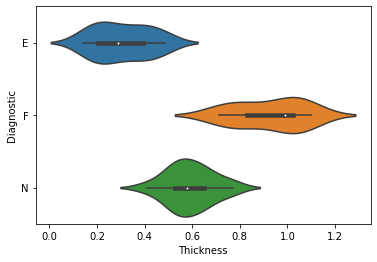

In [8]:
sns.violinplot(y='Diagnostic', x='Thickness', data = df)

Sau đó, Nhi dùng hàm dmatrics của patsy để tạo ra 1 design matrix X gồm 3 dummy variables của biến Diagnostic, và không chứa intercept

In [10]:
form = 'Thickness ~ Diagnostic - 1'

Y, X = dmatrices(form,
                 data=df,
                 return_type='dataframe')

Chuyển data type của X và Y thành float32:

In [11]:
X = X.astype('float32')

In [12]:
Y = Y.astype('float32')

# Bước 2: Dựng mô hình GLM bằng probflow

Tiếp theo, ta tạo ra class mô hình GLM, kế thừa cấu trúc và tính năng của class ContinuousModel của probflow.

Mô hình này có 3 nhóm tham số cần xác định: 

Ma trận W (hay Mu) gồm 3 tham số w1, w2, w3 tương ứng với trung bình Thickness tại mỗi phân nhóm E,F và N

nu và Sigma tương ứng với df và scale của phân phối Student t của Thickness

Hàm likelihood của mô hình cho phép ước lượng Thickness theo phân phối Student t với 3 tham số df = $\nu$, scale = $\sigma$, và location = $\mu \sim \mathbf{x}^\top \mathbf{w} = x_1 w_1 + x_2 w_2 + x_3 w_3$

Chú ý: nu luôn có giá trị dương, do đó dùng class pf.PositiveParameter, sigma dùng class pf.ScaleParameter, còn mu có dimension = số cột trong design matrix X

In [13]:
class GLM(pf.ContinuousModel):

    def __init__(self, dims):
        self.w = pf.Parameter([dims, 1], name = 'Mu')
        self.nu = pf.PositiveParameter(name = 'Nu')
        self.s = pf.ScaleParameter(name = 'Sigma')
    
    def __call__(self, x):
        return pf.StudentT(df = self.nu(),
                           loc = x.values @ self.w(), 
                           scale = self.s())

In [14]:
model = GLM(3)

# Bước 3: Huấn luyện mô hình từ dữ liệu
 
Nhi train mô hình GLM vừa tạo ra trên tập dữ liệu X,Y, với batch_size = 8 và 500 epochs

In [15]:
model.fit(X,Y, 
          lr = 0.01, 
          batch_size=8, 
          epochs=500)

# Bước 4 : Suy diễn thống kê

Sau khi huấn luyện xong, mô hình đã sẵn sàng cho ta sử dụng để suy diễn.
Trước hết ta kiểm tra đối chiếu phân bố hậu nghiệm của 3 tham số w1, w2, w3 với giá trị trung bình quan sát được ở 3 phân nhóm;

In [16]:
model.posterior_mean()

{'Mu': array([[0.3056469 ],
        [0.94337726],
        [0.5879702 ]], dtype=float32),
 'Nu': array([2.1327271], dtype=float32),
 'Sigma': array([0.09409102], dtype=float32)}

In [9]:
df.groupby('Diagnostic')['Thickness'].describe()

,count,mean,std,min,25%,50%,75%,max
Diagnostic,,,,,,,,
E,14.0,0.307497,0.115139,0.142701,0.206489,0.289362,0.393588,0.486870
F,9.0,0.922959,0.143293,0.712176,0.831632,0.990151,1.024771,1.100068
N,15.0,0.590980,0.095471,0.409640,0.529445,0.580132,0.649025,0.772808


Kết quả cho thấy mô hình phù hợp rất tốt với dữ liệu thực tế.

Tiếp theo, Nhi lấy mẫu 5 chuỗi MCMC với độ dài mỗi chuỗi = 1000 lượt, cho riêng nhóm tham số Mu (W), và lưu lại dưới array post_mu

In [17]:
post_mu = model.posterior_sample(n=5000)['Mu'].reshape(5000,3)

In [18]:
post_mu

array([[0.30232286, 0.8327245 , 0.59410244],
       [0.30166784, 0.9557079 , 0.58349615],
       [0.29719126, 0.95505023, 0.603168  ],
       ...,
       [0.22437584, 0.9864429 , 0.56533927],
       [0.31160855, 0.8354949 , 0.575218  ],
       [0.30561846, 0.86812717, 0.50443906]], dtype=float32)

Tuy nhiên, mục tiêu của chúng ta là so sánh, hay khảo sát mức độ khác biệt giữa 2 phân nhóm (bắt cặp tuần tự);

Nhi lại dùng thủ thuật combinations và dictionary như trong bài trước để tạo ra dữ liệu so sánh bắt cặp giữa E và F, E và N, F và N...

In [123]:
from itertools import combinations
from collections import defaultdict

In [158]:
def post_hoc(grp_names = ['Emphysema', 'Fibrosis', 'Normal'],
            post_mu = post_mu,
            n_chain = 5):
    comb = combinations(range(len(grp_names)),2)
    pairwise = defaultdict()
    
    for i in comb:
        pair_name = grp_names[i[0]] + ' vs ' + grp_names[i[1]]
        pairwise[pair_name] = np.diff(post_mu[:,i], axis = 1).flatten().reshape(n_chain, post_mu.shape[0]//n_chain)
    
    return az.from_dict(pairwise)

Kết quả của hàm post_hoc cho ta 1 object dữ liệu arviz:

Lúc này mọi chuyện chỉ còn là trò chơi đơn giản;

## Phân phối hậu nghiệm của khác biệt :

In [159]:
pw = post_hoc(grp_names = ['Emphysema', 'Fibrosis', 'Normal'],
            post_mu = post_mu,
             n_chain = 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000122F0901348>,
      dtype=object)

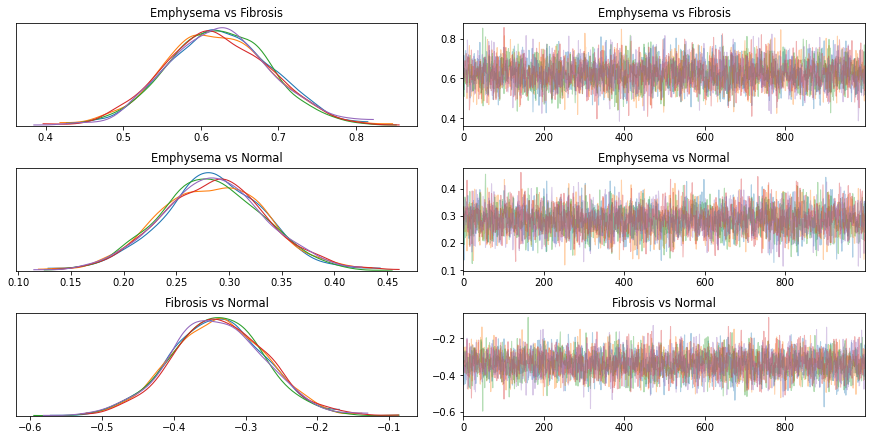

In [161]:
az.plot_trace(pw)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000122F7FE2148>,
      dtype=object)

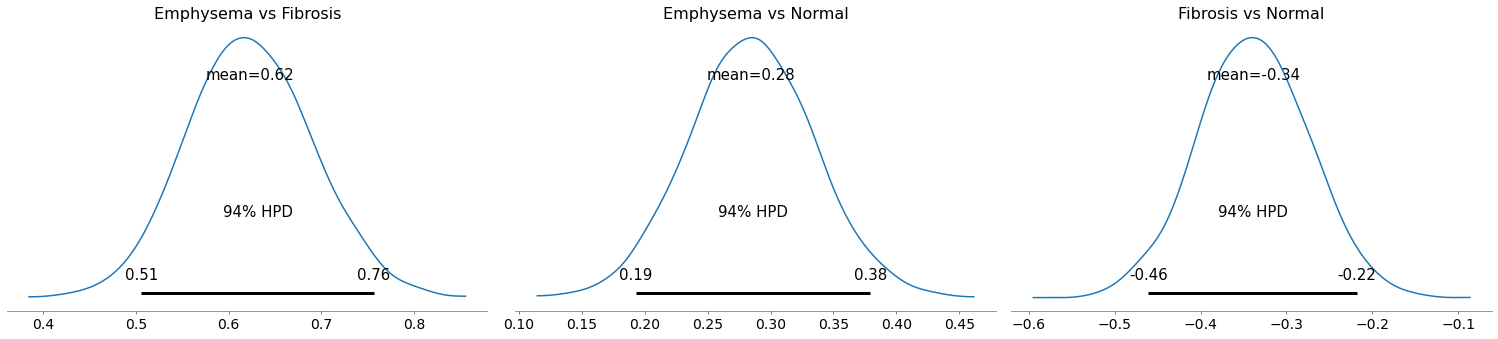

In [162]:
az.plot_posterior(pw)

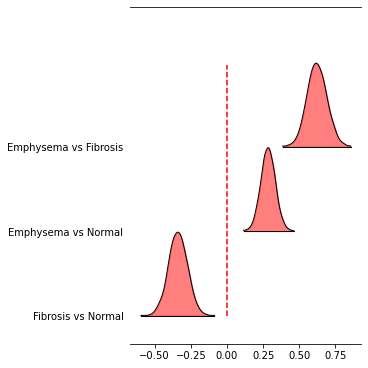

In [171]:
az.plot_forest(pw,
               kind='ridgeplot',
               colors= 'red',
               ridgeplot_alpha = 0.5,
               linewidth=1,
               combined=True,
               credible_interval = 0.95,
               ridgeplot_overlap=1.,
               figsize=(5,5))

plt.vlines(x=0, ymin = 0, ymax = 3, color = 'red', linestyles='dashed')

In [172]:
az.summary(pw, 
           credible_interval=0.95, 
           kind = 'stats',
          stat_funcs={'Median': np.median})

,mean,sd,hpd_2.5%,hpd_97.5%,Median
Emphysema vs Fibrosis,0.623,0.067,0.495,0.757,0.622
Emphysema vs Normal,0.285,0.050,0.188,0.383,0.285
Fibrosis vs Normal,-0.338,0.064,-0.469,-0.218,-0.338


Dựa vào phân phối hậu nghiệm của 3 cặp so sánh, ta có thể kết luận:

Fibrosis làm tăng Thickness trung bình 0.623 micromet (95%CI: 0.495 - 0.757) so với nhóm Emphysema,

Emphysema làm giảm Thickness trung bình 0.285 micromet (0.188 - 0.383) so với nhóm Normal

Cuối cùng, Fibrosis làm tăng Thickness trung bình 0.338 micromet (CI95%: 0.218 - 0.469) so với nhóm Normal.

# Kết luận:

Probflow cho phép dựng và suy diễn một mô hình GLM đa biến dễ dàng, điều này cũng có nghĩa là probflow rất hữu ích cho các bài toán phân tích phương sai cổ điển, vì hầu như tất cả chúng đều dẫn ta về mô hình hồi quy GLM, từ t-est, ANOVA, MANOVA, ANCOVA, MANOVA, ... 

Chúc các bạn thực hành vui và hện gặp lại...